In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [43]:
prices_close = pd.read_csv('sp500_prices_close.csv', index_col=0, parse_dates=True)
prices_close = prices_close.dropna()
print(prices_close.head())


                    A       AAPL       ABBV        ABT       ACGL         ACN  \
Date                                                                            
2020-01-02  82.711060  72.538506  70.326820  78.555801  41.268997  192.514999   
2020-01-03  81.383072  71.833305  69.659286  77.598145  41.221451  192.194382   
2020-01-06  81.623665  72.405685  70.209023  78.004715  41.383106  190.939362   
2020-01-07  81.873848  72.065140  69.808502  77.571037  41.040779  186.816956   
2020-01-08  82.682205  73.224403  70.303268  77.887245  40.631893  187.183441   

                  ADBE         ADI        ADM         ADP  ...         WY  \
Date                                                       ...              
2020-01-02  334.429993  108.511078  39.126694  150.852661  ...  23.822412   
2020-01-03  331.809998  106.600868  39.050323  150.533798  ...  23.862932   
2020-01-06  333.709991  105.348450  38.744835  150.737503  ...  23.814302   
2020-01-07  333.390015  107.745201  38.278130  

# Engle-Granger test:

Assuming 2 time-series $X_{t}$ and $Y_{t}$ are I(1), they are cointegrated if there exist scalar $\beta$ such that :
 
$u_{t}= Y_{t}​− \beta X_{t}$ satisfies $u_{t}$~I(0)  

In [4]:
# Differentiation of a time-series
def diff(series, d=1):
    """Return Δ^d series (d-th difference)."""
    out = series.copy()
    for _ in range(d):
        out = out.diff()
    return out.dropna()

In [5]:
# ADF test
def adf_test(series, max_lags=None, ic='AIC', trend='c'):
    """
    trend: 'n' (no const), 'c' (const), 'ct' (const+trend), 'ctt' (const+trend+quad)
    ic:    'AIC' or 'BIC' for autolag selection
    """
    series = series.dropna()
    res = adfuller(series, maxlag=max_lags, regression=trend, autolag=ic)
    out = {
        'ADF stat': res[0],
        'p-value':  res[1],
        '#lags':    res[2],
        '#obs':     res[3],
        'crit':     res[4],   # dict with 1%, 5%, 10%
        'icbest':   res[5] if len(res) > 5 else None
    }
    return out

In [6]:
#checks the order of integration of a time-series
def is_Id(series, d=1, adf_trend='c', ic='AIC'):
    """Quick check: not stationary at level but stationary after one diff."""
    r0 = adf_test(series, trend=adf_trend, ic=ic)['p-value']
    r1 = adf_test(diff(series, d=d), trend='n', ic=ic)['p-value']
    return (r0 > 0.05) and (r1 < 0.05)

In [ ]:
print(adf_test(diff(prices_close['AAPL']), trend='c'))

{'ADF stat': -35.938708244717134, 'p-value': 0.0, '#lags': 0, '#obs': 1256, 'crit': {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}, 'icbest': 5928.407008002422}


In [ ]:
print(is_Id(prices_close['AAPL'],d=0))
print(is_Id(prices_close['AAPL'],d=1))

False
True


In [9]:
def engle_granger(X,Y, p_val=0.05):
    X, Y = X.align(Y, join="inner")
    if not (is_Id(X,d=1) and is_Id(Y,d=1)):
        return None
    else:
        score, p_value, _ = coint(X, Y)

        if p_value < p_val:
            X_const = sm.add_constant(X)
            model = sm.OLS(Y, X_const).fit()
            beta = model.params[1]  # slope coefficient
            alpha = model.params[0]  # intercept
            
            return beta, alpha, p_value, score
        else:
            return None

In [ ]:
print(engle_granger(prices_close['AAPL'], prices_close['MSFT'], p_val=0.05))

None


# Finding cointegrated pairs in the SP500

In [15]:
def cointegrated_pairs(df, p_val=0.05):
    pairs=[]
    for i in range(df.shape[1]):
        for j in range(i+1,df.shape[1]):
            if i!=j:
                    X = df.iloc[:,i]
                    Y = df.iloc[:,j]
                    if not engle_granger(X,Y, p_val=p_val) is None: 
                        beta, alpha, p_value, score = engle_granger(X,Y, p_val=p_val)
                        if p_value < p_val:
                            print(f"Cointegrated pair: {df.columns[i]} and {df.columns[j]} with p-value {p_value}")
                            pairs.append([df.columns[i], df.columns[j], beta, alpha, p_value, score])
    return pairs

In [ ]:
## Took too long to run
# pairs = cointegrated_pairs(returns_close, p_val=0.01)
pairs=  cointegrated_pairs(returns_close, p_val=10**-4)
print(pairs)

In [16]:
pair_test=[['AAPL', 'MSFT', 1.057, -3.123, 0.0001, -4.321],['GOOGL', 'AMZN', 0.876, 2.456, 0.00005, -4.567],['FB', 'TWTR', 1.234, -1.234, 0.0002, -4.123],['NFLX', 'DIS', 0.987, 0.567, 0.00015, -4.234],['AAPL', 'GOOGL', 1.345, -2.345, 0.0003, -4.456]]

# Finding the tickers that represent the whole index

In [17]:
def minimum_pairs(pairs):
    Min=[]
    Min.append(pairs[0][0])
    Min.append(pairs[0][1])
    pairs.pop(0)
    while len(pairs)>0:
        if pairs[0][0] in Min and pairs[0][1] in Min:
            pairs.pop(0)
        else:
            if pairs[0][0] not in Min:
                Min.append(pairs[0][0])
            if pairs[0][1] not in Min:
                Min.append(pairs[0][1])
            pairs.pop(0)
    return Min, len(Min)

In [18]:
print(minimum_pairs(pair_test))

(['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'FB', 'TWTR', 'NFLX', 'DIS'], 8)


# Building investing strategies (Portfolio Building)

In [37]:
def buy_and_hold(df,ticker,capital=100):
    price=[]
    for i in range(len(df)):
        price.append(df[ticker].iloc[i]*capital)
    return price

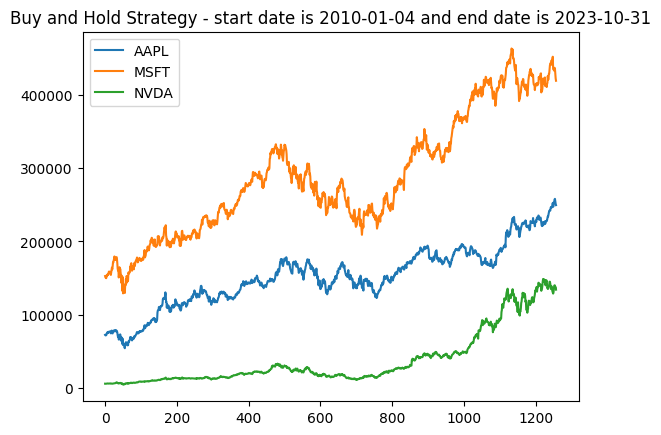

In [ ]:
plt.plot(buy_and_hold(prices_close,'AAPL',capital=1000))
plt.plot(buy_and_hold(prices_close,'MSFT',capital=1000))
plt.plot(buy_and_hold(prices_close,'NVDA',capital=1000))
plt.title('Buy and Hold Strategy - start date is 2010-01-04 and end date is 2023-10-31')
plt.legend(['AAPL','MSFT','NVDA'])
plt.show()

In [40]:
def portfolio(df,tickers,capitals):
    port=[]
    for i in range(len(df)):
        total=0
        for j in range(len(tickers)):
            total+=df[tickers[j]].iloc[i]*capitals[j]
        port.append(total)
    return port

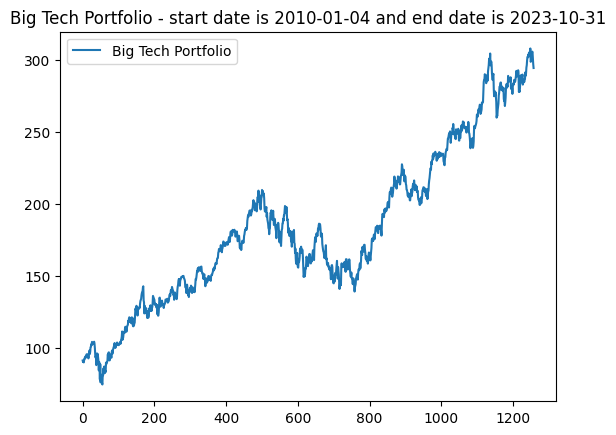

In [ ]:
bigtech=portfolio(prices_close,['AAPL','MSFT','NVDA'],[0.4,0.4,0.2])
plt.plot(bigtech)
plt.title('Big Tech Portfolio - start date is 2010-01-04 and end date is 2023-10-31')
plt.legend(['Big Tech Portfolio'])
plt.show()

In [ ]:
def best_portfolio(df,tickers): ## finding the best portfolio with the highest return using function optimization
    
    def herfindahl_hirschman_index(weights):
        """Calculate the Herfindahl-Hirschman Index (HHI) for a given set of weights."""
        return sum(w**2 for w in weights)
    ## Adding diversification constraint (Herfindahl-Hirschman Index)
    def objective_function(weights):
        port = portfolio(df, tickers, weights)
        return -((port[-1]-port[0])/port[0]) + 0.5 * herfindahl_hirschman_index(weights)  # Minimize negative return

    constraints = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})  # Weights must sum to 1
    bounds = tuple((0, 1) for _ in tickers)  # Weights must be between 0 and 1
    initial_weights = [1/len(tickers)] * len(tickers)

    result = minimize(objective_function, initial_weights, bounds=bounds, constraints=constraints)

    return result.x, -result.fun  # Return optimal weights and maximum return


In [ ]:
best_weights, _ = best_portfolio(prices_close,['MSFT','GOOGL','AMZN'])

1.0


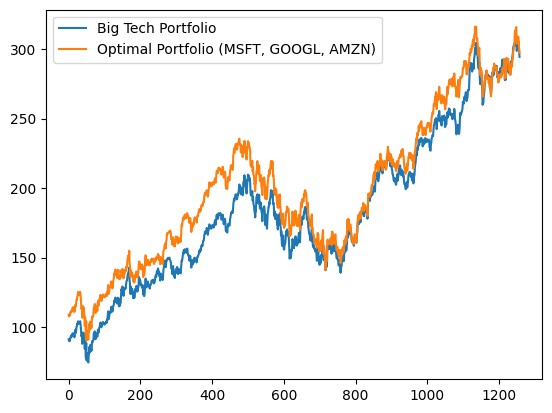

In [ ]:
plt.plot(bigtech)
plt.plot(portfolio(prices_close,['MSFT','GOOGL','AMZN'],best_weights))
plt.legend(['Big Tech Portfolio', 'Optimal Portfolio'])
plt.show()

In [ ]:
def cointegrated_strat(df,pairs, initial_capital=10000):
    capital=initial_capital
    for pair in pairs:
        ticker1=pair[0]
        ticker2=pair[1]
        beta=pair[2]
        alpha=pair[3]
        price1=buy_and_hold(df,ticker1)
        price2=buy_and_hold(df,ticker2)
        
        # Calculate the spread
        spread = np.array(price2) - beta * np.array(price1) - alpha
        
        # Calculate the mean and standard deviation of the spread
        spread_mean = np.mean(spread)
        spread_std = np.std(spread)
        
        # Set entry and exit thresholds
        entry_threshold = spread_mean + spread_std
        exit_threshold = spread_mean
        
        position1 = 0  # Position in ticker1
        position2 = 0  # Position in ticker2
        
        for t in range(len(spread)):
            if spread[t] > entry_threshold and position1 == 0 and position2 == 0:
                # Short ticker2 and long ticker1
                position1 = capital / price1[t]  # Buy as many shares of ticker1 as possible
                position2 = -capital / price2[t]  # Short as many shares of ticker2 as possible
                capital = 0  # All capital is now invested
            
            elif spread[t] < exit_threshold and position1 != 0 and position2 != 0:
                # Close positions
                capital += position1 * price1[t] + position2 * price2[t]
                position1 = 0
                position2 = 0
        
        # At the end of the period, close any open positions
        if position1 != 0 and position2 != 0:
            capital += position1 * price1[-1] + position2 * price2[-1]
    
    return capital